## IMPORTS


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## LOAD DATASET

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Part A: Data Preprocessing and Exploratory Analysis

### 1. Dataset structure

In [4]:
n_samples = len(train)
n_features = train.shape[1] - 1  # excluding target
print('Number of samples:', n_samples)
print('Number of features:', n_features)
print('Data types:')
print(train.dtypes)
print('First few rows:')
train.head(10)

Number of samples: 41348
Number of features: 6
Data types:
neighbourhood_group     object
room_type               object
minimum_nights         float64
amenity_score          float64
number_of_reviews      float64
availability_365       float64
price_class              int64
dtype: object
First few rows:


,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
0,Manhattan,NaN,2.0,82.5,15.0,254.0,3
1,Manhattan,Private room,2.0,53.7,1.0,0.0,1
2,Brooklyn,Private room,2.0,47.8,70.0,90.0,1
3,Manhattan,Entire home/apt,2.0,58.8,1.0,NaN,1
4,Bronx,Private room,2.0,32.2,0.0,89.0,1
5,Manhattan,Private room,5.0,48.6,2.0,6.0,1
6,Manhattan,Private room,2.0,11.5,12.0,45.0,0
7,Manhattan,Entire home/apt,2.0,84.9,9.0,0.0,2
8,Brooklyn,Entire home/apt,2.0,44.2,23.0,190.0,1
9,Manhattan,Entire home/apt,30.0,27.7,3.0,82.0,0


### 2. Missing values


In [5]:
print(train.isnull().sum())

neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
price_class               0
dtype: int64


In [6]:
# Drop rows with any missing value
train_clean = train.dropna()
print('Rows after dropping missing:', len(train_clean))

Rows after dropping missing: 36234


### 3. Class distribution of target (price_class)

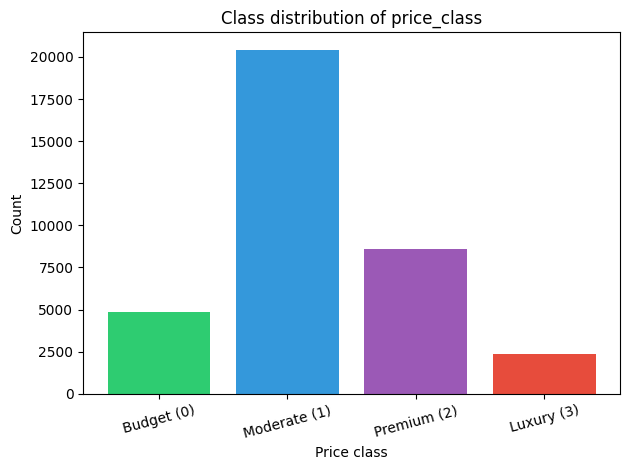

Counts: {0: 4837, 1: 20437, 2: 8617, 3: 2343}
Imbalance: largest/smallest ratio = 8.72


In [7]:
class_counts = train_clean['price_class'].value_counts().sort_index()
labels = ['Budget (0)', 'Moderate (1)', 'Premium (2)', 'Luxury (3)']
plt.bar(labels, class_counts.values, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
plt.xlabel('Price class')
plt.ylabel('Count')
plt.title('Class distribution of price_class')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
print('Counts:', class_counts.to_dict())
print('Imbalance: largest/smallest ratio = {:.2f}'.format(class_counts.max() / class_counts.min()))

### 4. Encode categorical variables

Using **one-hot encoding** for `neighbourhood_group` and `room_type`: no ordinal relationship between categories; one-hot keeps the model from assuming order and is standard for tree/linear/MLP inputs.

In [8]:
# One-hot encode categoricals (fit on train_clean later on)
train_enc = pd.get_dummies(train_clean, columns=['neighbourhood_group', 'room_type'], drop_first=False)
# Convert True/False to 1/0
dummy_cols = [c for c in train_enc.columns if c.startswith('neighbourhood_group_') or c.startswith('room_type_')]
train_enc[dummy_cols] = train_enc[dummy_cols].astype(int)
print('Columns after encoding:', list(train_enc.columns))
print(train_enc.head(10).to_string())

Columns after encoding: ['minimum_nights', 'amenity_score', 'number_of_reviews', 'availability_365', 'price_class', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room']
    minimum_nights  amenity_score  number_of_reviews  availability_365  price_class  neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  neighbourhood_group_Manhattan  neighbourhood_group_Queens  neighbourhood_group_Staten Island  room_type_Entire home/apt  room_type_Private room  room_type_Shared room
1              2.0           53.7                1.0               0.0            1                          0                             0                              1                           0                                  0                          0                       1                      0
2              2.0       

### 5. Normalize numerical features

Using **z-score (standardization)**: subtract mean, divide by std. Puts all numerical features on similar scale so no single feature dominates by magnitude.

In [9]:
# Z-score: (x - mean) / std
num_cols = ['minimum_nights', 'number_of_reviews', 'availability_365', 'amenity_score']
mean_ = train_enc[num_cols].mean()
std_ = train_enc[num_cols].std()
train_enc[num_cols] = (train_enc[num_cols] - mean_) / (std_ + 1e-8)
print(train_enc[num_cols].head(10))

    minimum_nights  number_of_reviews  availability_365  amenity_score
1        -0.246600          -0.515051         -0.870460       0.089631
2        -0.246600           1.018345         -0.185884      -0.213440
4        -0.246600          -0.537274         -0.193490      -1.014781
5        -0.092553          -0.492828         -0.824822      -0.172346
6        -0.246600          -0.270597         -0.528172      -2.078097
7        -0.246600          -0.337266         -0.870460       1.692311
8        -0.246600          -0.026142          0.574757      -0.398365
9         1.191173          -0.470605         -0.246735      -1.245936
10       -0.246600           1.796154         -0.870460      -0.331587
12       -0.297949          -0.492828         -0.870460      -0.074747


### 6. Feature vs target visualizations

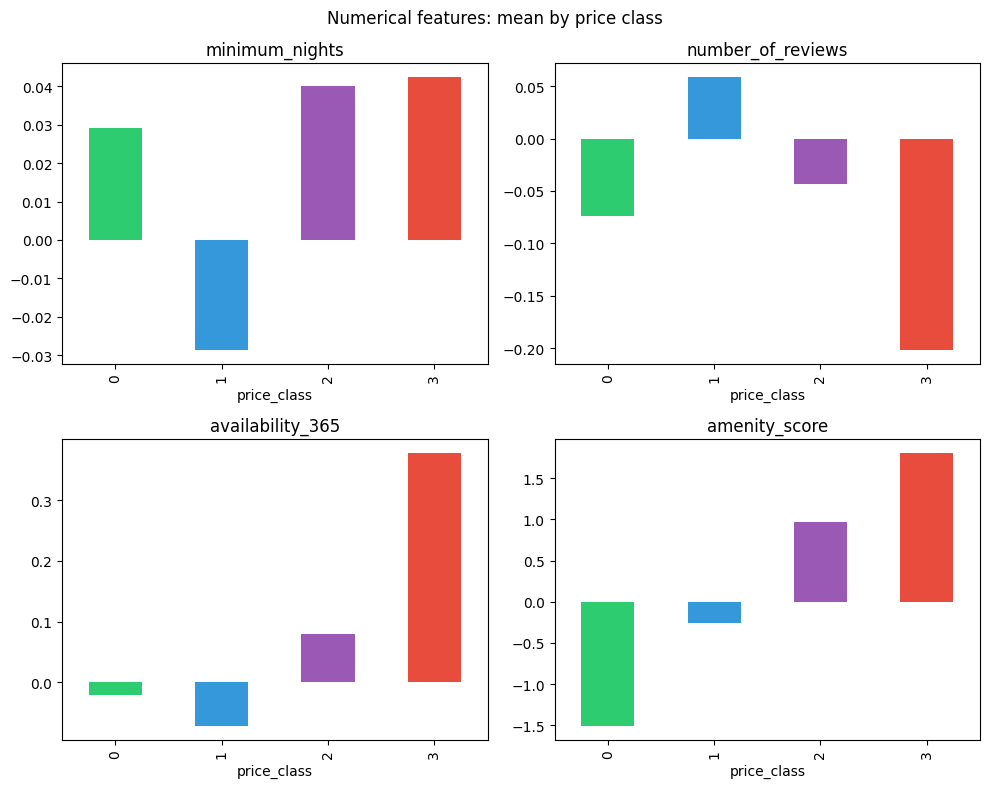

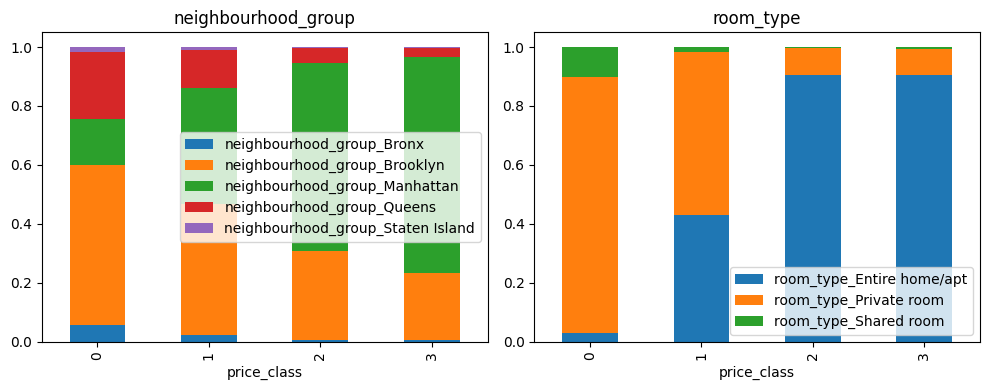

In [10]:
# Numerical: mean by price class
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flat, num_cols):
    means = train_enc.groupby('price_class')[col].mean()
    means.plot.bar(ax=ax, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
    ax.set_title(col)
    ax.set_xlabel('price_class')
plt.suptitle('Numerical features: mean by price class')
plt.tight_layout()
plt.show()

# Categorical: proportion within each price class (stacked bar)
ng_cols = [c for c in train_enc.columns if c.startswith('neighbourhood_group_')]
rt_cols = [c for c in train_enc.columns if c.startswith('room_type_')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
train_enc.groupby('price_class')[ng_cols].mean().plot.bar(stacked=True, ax=ax1, legend=True)
train_enc.groupby('price_class')[rt_cols].mean().plot.bar(stacked=True, ax=ax2, legend=True)
ax1.set_title('neighbourhood_group'); ax2.set_title('room_type')
ax1.set_xlabel('price_class'); ax2.set_xlabel('price_class')
plt.tight_layout()
plt.show()

### 7. Correlation matrix (numerical features)

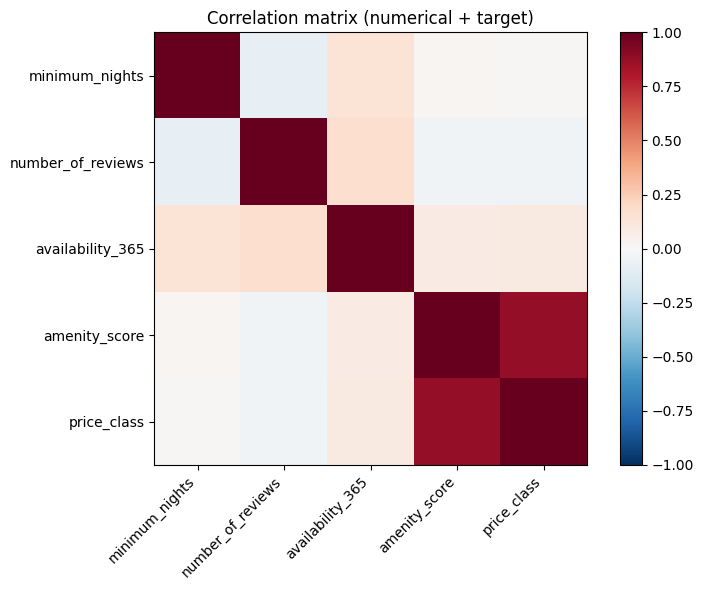

                   minimum_nights  number_of_reviews  availability_365  \
minimum_nights               1.00              -0.08              0.14   
number_of_reviews           -0.08               1.00              0.17   
availability_365             0.14               0.17              1.00   
amenity_score                0.02              -0.03              0.08   
price_class                  0.01              -0.03              0.09   

                   amenity_score  price_class  
minimum_nights              0.02         0.01  
number_of_reviews          -0.03        -0.03  
availability_365            0.08         0.09  
amenity_score               1.00         0.88  
price_class                 0.88         1.00  


In [11]:
corr = train_enc[num_cols + ['price_class']].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation matrix (numerical + target)')
plt.tight_layout()
plt.show()
print(corr.round(2))

---
## Part B(a): Two-layer perceptron from scratch (NumPy only)

- Two hidden layers; forward pass, cross-entropy loss, backward pass (no autograd).
- Train with (a) Sigmoid and (b) ReLU for hidden layers; vanilla batch gradient descent, ≥200 iterations.
- Single plot: training and validation accuracy vs iterations (both activations).

In [12]:
# Feature columns (all except target)
feature_cols = [c for c in train_enc.columns if c != 'price_class']
feature_cols = sorted(feature_cols)  # stable order
X_all = train_enc[feature_cols].values.astype(np.float64)
y_all = train_enc['price_class'].values.astype(np.int32)
n_classes = 4
input_dim = X_all.shape[1]
print('Input dim:', input_dim, 'Classes:', n_classes)

Input dim: 12 Classes: 4


In [13]:
# Train/validation split (80/20)
np.random.seed(42)
idx = np.random.permutation(len(X_all))
split = int(0.8 * len(idx))
train_idx, val_idx = idx[:split], idx[split:]
X_train, y_train = X_all[train_idx], y_all[train_idx]
X_val, y_val = X_all[val_idx], y_all[val_idx]
print('Train size:', len(X_train), 'Val size:', len(X_val))

Train size: 28987 Val size: 7247


In [14]:
def onehot(y, n_classes):
    n = len(y)
    out = np.zeros((n, n_classes))
    out[np.arange(n), y] = 1
    return out

def softmax(z):
    e = np.exp(z - z.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

In [15]:
class TwoLayerMLP:
    """Two hidden layers, output softmax. Activation for hidden layers: 'sigmoid' or 'relu'."""

    def __init__(self, input_dim, hidden1, hidden2, n_classes, activation='sigmoid', seed=42):
        self.act_name = activation  # 'sigmoid' or 'relu' for both hidden layers
        np.random.seed(seed)
        # Layer 1: input -> hidden1
        self.W1 = np.random.randn(input_dim, hidden1) * 0.1  # weights
        self.b1 = np.zeros(hidden1)  # biases
        # Layer 2: hidden1 -> hidden2
        self.W2 = np.random.randn(hidden1, hidden2) * 0.1
        self.b2 = np.zeros(hidden2)
        # Layer 3 (output): hidden2 -> n_classes logits
        self.W3 = np.random.randn(hidden2, n_classes) * 0.1
        self.b3 = np.zeros(n_classes)

    def _act(self, z):
        # Apply activation element-wise (sigmoid or ReLU)
        if self.act_name == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clip to avoid overflow
        return np.maximum(0, z)  # ReLU

    def _act_deriv(self, a, z):
        # Derivative of activation w.r.t. z (for backprop)
        if self.act_name == 'sigmoid':
            return a * (1 - a)  # sigmoid'(z) = sigma(z)*(1-sigma(z))
        return (z > 0).astype(np.float64)  # ReLU': 1 if z>0 else 0

    def forward(self, x):
        # Store inputs and activations for backward pass
        self._x = x
        # Layer 1: z1 = xW1 + b1, a1 = act(z1)
        self._z1 = x @ self.W1 + self.b1
        self._a1 = self._act(self._z1)
        # Layer 2: z2 = a1W2 + b2, a2 = act(z2)
        self._z2 = self._a1 @ self.W2 + self.b2
        self._a2 = self._act(self._z2)
        # Output: logits = a2W3 + b3, then softmax -> probabilities
        self._logits = self._a2 @ self.W3 + self.b3
        self._probs = softmax(self._logits)
        return self._probs

    def cross_entropy_loss(self, y_onehot):
        # L = -mean over batch of sum_k(y_k * log(p_k))
        p = np.clip(self._probs, 1e-12, 1 - 1e-12)  # avoid log(0)
        return np.mean(-np.sum(y_onehot * np.log(p), axis=1))

    def backward(self, y_onehot, lr):
        batch = y_onehot.shape[0]
        # Gradient of CE loss w.r.t. logits: dL/dlogits = p - y
        d_logits = self._probs - y_onehot
        d_logits /= batch  # we used mean loss
        # Update output layer (W3, b3) and get gradient w.r.t. a2
        self.W3 -= lr * (self._a2.T @ d_logits)
        self.b3 -= lr * d_logits.sum(axis=0)
        d_a2 = d_logits @ self.W3.T
        # Back through layer 2: chain rule -> d_z2 = d_a2 * act'(z2)
        d_z2 = d_a2 * self._act_deriv(self._a2, self._z2)
        self.W2 -= lr * (self._a1.T @ d_z2)
        self.b2 -= lr * d_z2.sum(axis=0)
        d_a1 = d_z2 @ self.W2.T
        # Back through layer 1: d_z1 = d_a1 * act'(z1)
        d_z1 = d_a1 * self._act_deriv(self._a1, self._z1)
        self.W1 -= lr * (self._x.T @ d_z1)
        self.b1 -= lr * d_z1.sum(axis=0)
        # Return gradient magnitudes for Part B(b) analysis
        return np.mean(np.abs(self._x.T @ d_z1)), np.mean(np.abs(self._a1.T @ d_z2))

    ## for part c-b
    def grad_winning_wrt_input(self, x):
        """Section 2.8: gradient of winning class output w.r.t. input (for feature attribution). Returns (N, D)."""
        self.forward(x)
        N = x.shape[0]
        m = np.argmax(self._probs, axis=1)  # winning class per sample
        d_probs = np.zeros_like(self._probs)
        d_probs[np.arange(N), m] = 1.0  # gradient of om w.r.t. probs
        # Softmax backward: d_logits = p * (d_probs - (p*d_probs).sum(axis=1, keepdims=True))
        d_logits = self._probs * (d_probs - (self._probs * d_probs).sum(axis=1, keepdims=True))
        d_a2 = d_logits @ self.W3.T
        d_z2 = d_a2 * self._act_deriv(self._a2, self._z2)
        d_a1 = d_z2 @ self.W2.T
        d_z1 = d_a1 * self._act_deriv(self._a1, self._z1)
        d_x = d_z1 @ self.W1.T
        return d_x

In [16]:
def accuracy(probs, y):
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == y)

def train_mlp(X_tr, y_tr, X_v, y_v, activation, n_iters=200, lr=0.5, hidden1=64, hidden2=32):
    n_classes = 4
    D = X_tr.shape[1]
    mlp = TwoLayerMLP(D, hidden1, hidden2, n_classes, activation=activation)
    y_tr_oh = onehot(y_tr, n_classes)
    hist = {'train_acc': [], 'val_acc': [], 'grad_mag1': [], 'grad_mag2': []}
    for it in range(n_iters):
        probs = mlp.forward(X_tr)
        loss = mlp.cross_entropy_loss(y_tr_oh)
        g1, g2 = mlp.backward(y_tr_oh, lr)
        hist['grad_mag1'].append(g1)
        hist['grad_mag2'].append(g2)
        hist['train_acc'].append(accuracy(mlp.forward(X_tr), y_tr))
        hist['val_acc'].append(accuracy(mlp.forward(X_v), y_v))
    return mlp, hist

In [17]:
# Train with Sigmoid (vanilla batch GD: full batch per iteration)
mlp_sigmoid, hist_sigmoid = train_mlp(X_train, y_train, X_val, y_val, 'sigmoid', n_iters=200, lr=0.5)
print('Sigmoid – Final train acc: {:.4f}, val acc: {:.4f}'.format(hist_sigmoid['train_acc'][-1], hist_sigmoid['val_acc'][-1]))

Sigmoid – Final train acc: 0.5659, val acc: 0.5566


In [18]:
# Train with ReLU
mlp_relu, hist_relu = train_mlp(X_train, y_train, X_val, y_val, 'relu', n_iters=200, lr=0.1)
print('ReLU – Final train acc: {:.4f}, val acc: {:.4f}'.format(hist_relu['train_acc'][-1], hist_relu['val_acc'][-1]))

ReLU – Final train acc: 0.8181, val acc: 0.8224


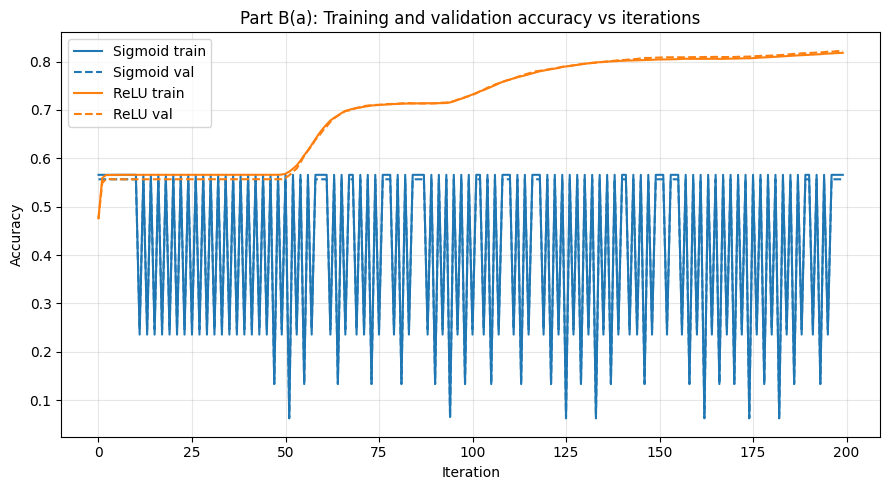

In [19]:
# Single plot: training and validation accuracy vs iterations (both activations)
plt.figure(figsize=(9, 5))
plt.plot(hist_sigmoid['train_acc'], label='Sigmoid train', color='C0')
plt.plot(hist_sigmoid['val_acc'], label='Sigmoid val', color='C0', linestyle='--')
plt.plot(hist_relu['train_acc'], label='ReLU train', color='C1')
plt.plot(hist_relu['val_acc'], label='ReLU val', color='C1', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Part B(a): Training and validation accuracy vs iterations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Part B(b): Gradient magnitude comparison across layers

Using the trained networks from Part B(a),  compare the **average magnitude of gradients** for the first and second hidden layer weights as a function of iterations (for both Sigmoid and ReLU).

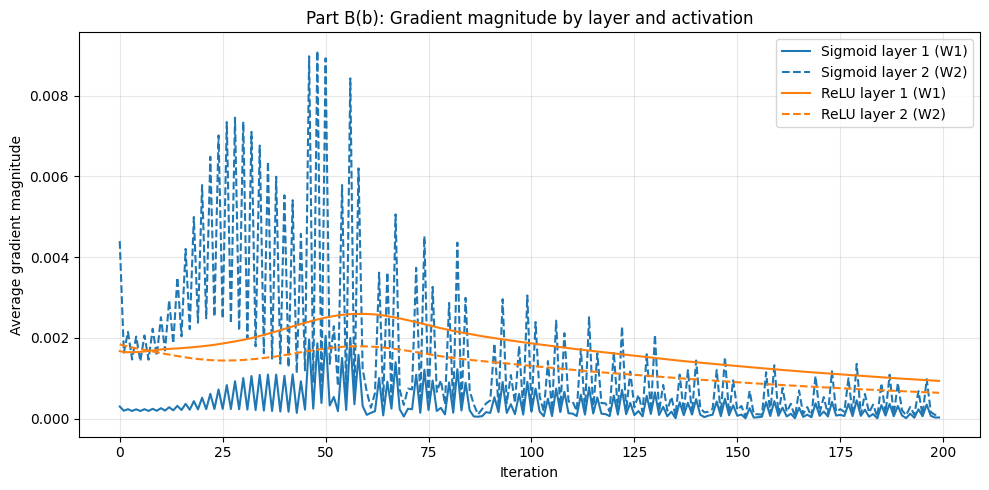

In [20]:
# Gradient magnitudes were recorded during training (hist_*['grad_mag1'], ['grad_mag2']). Plot vs iteration.
plt.figure(figsize=(10, 5))
plt.plot(hist_sigmoid['grad_mag1'], label='Sigmoid layer 1 (W1)', color='C0')
plt.plot(hist_sigmoid['grad_mag2'], label='Sigmoid layer 2 (W2)', color='C0', linestyle='--')
plt.plot(hist_relu['grad_mag1'], label='ReLU layer 1 (W1)', color='C1')
plt.plot(hist_relu['grad_mag2'], label='ReLU layer 2 (W2)', color='C1', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Average gradient magnitude')
plt.title('Part B(b): Gradient magnitude by layer and activation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Part C(b): Gradient-based feature attribution (Section 2.8)

Using the trained ReLU MLP from Part B(a), we implement the method from Section 2.8: compute the gradient of the **winning class output** w.r.t. each input feature, then aggregate over correctly classified training instances to rank features by influence.

In [21]:
# Use trained ReLU model; restrict to correctly classified training instances (Section 2.8)
probs_tr = mlp_relu.forward(X_train)
preds_tr = np.argmax(probs_tr, axis=1)
correct = (preds_tr == y_train)
X_correct = X_train[correct]
y_correct = y_train[correct]
print('Correctly classified training samples:', X_correct.shape[0])

# Gradient of winning output w.r.t. input for each sample (backprop to input)
grad_x = mlp_relu.grad_winning_wrt_input(X_correct)  # (N, D)

# Aggregate: average absolute gradient per feature (sensitivity)
avg_abs_grad = np.mean(np.abs(grad_x), axis=0)
ranked_idx = np.argsort(avg_abs_grad)[::-1]

# Ranked list of most influential features
print('\nRanked list of input features (most to least influential):')
for r, i in enumerate(ranked_idx):
    print('  {:2d}. {}  (avg |grad| = {:.6f})'.format(r+1, feature_cols[i], avg_abs_grad[i]))

Correctly classified training samples: 23715

Ranked list of input features (most to least influential):
   1. amenity_score  (avg |grad| = 0.350802)
   2. room_type_Entire home/apt  (avg |grad| = 0.096648)
   3. neighbourhood_group_Manhattan  (avg |grad| = 0.075656)
   4. room_type_Private room  (avg |grad| = 0.069716)
   5. neighbourhood_group_Bronx  (avg |grad| = 0.040947)
   6. neighbourhood_group_Brooklyn  (avg |grad| = 0.037738)
   7. neighbourhood_group_Queens  (avg |grad| = 0.032232)
   8. neighbourhood_group_Staten Island  (avg |grad| = 0.031439)
   9. room_type_Shared room  (avg |grad| = 0.029500)
  10. availability_365  (avg |grad| = 0.023611)
  11. minimum_nights  (avg |grad| = 0.016687)
  12. number_of_reviews  (avg |grad| = 0.011328)


**Interpretation and relation to Part A:**  
The ranked list matches Part A: **amenity_score** is by far the most influential (avg |grad| ≈ 0.35), then **room_type** (Entire home/apt, Private room) and **neighbourhood_group** (Manhattan, Bronx, Brooklyn, Queens, Staten Island), then the other numericals (availability_365, minimum_nights, number_of_reviews). In Part A we concluded amenity_score, room_type, and neighbourhood would be most important; the gradient-based ranking agrees—the model relies most on those features when predicting the winning class. So the attribution results support that the MLP learned sensible decision boundaries consistent with the EDA.

**Pseudocode for report (Section 2.8 feature attribution, code form):**

```
// Per-instance: gradient of winning output w.r.t. input
function grad_winning_wrt_input(model, x):
    p = model.forward(x)           // output probabilities (N x K)
    m = argmax(p, axis=1)          // winning class per sample
    d_probs = zeros_like(p)
    d_probs[arange(N), m] = 1     // one-hot at winning class
    d_logits = softmax_backward(p, d_probs)
    d_a2 = d_logits @ W3.T
    d_z2 = d_a2 * act_deriv(a2, z2)
    d_a1 = d_z2 @ W2.T
    d_z1 = d_a1 * act_deriv(a1, z1)
    d_x = d_z1 @ W1.T              // gradient w.r.t. input (N x D)
    return d_x

// Feature ranking (aggregate over correctly classified training)
correct = (model.predict(X_train) == y_train)
X_correct = X_train[correct]
grad_x = grad_winning_wrt_input(model, X_correct)
avg_abs_grad = mean(|grad_x|, axis=0)   // per-feature average
ranked = argsort(avg_abs_grad)[::-1]    // descending = most influential first
```

---
## Part D: Test evaluation and generalization analysis


In [22]:
# Validation set: 80/20 random split from train.csv (same distribution as train).
# Test: we only run inference (forward pass); no training on test.
# Preprocess test the same way as train (same encoding + train mean/std for normalization)
test_clean = test.dropna()
test_enc = pd.get_dummies(test_clean, columns=['neighbourhood_group', 'room_type'], drop_first=False)
# Align to train columns: same order, fill missing (e.g. category only in train) with 0
test_enc = test_enc.reindex(columns=train_enc.columns, fill_value=0)
dummy_cols = [c for c in test_enc.columns if c.startswith('neighbourhood_group_') or c.startswith('room_type_')]
test_enc[dummy_cols] = test_enc[dummy_cols].astype(int)
test_enc[num_cols] = (test_enc[num_cols] - mean_) / (std_ + 1e-8)

X_test = test_enc[feature_cols].values.astype(np.float64)
y_test = test_enc['price_class'].values.astype(np.int32)
print('Test size:', len(X_test))

# Accuracies
acc_train = hist_relu['train_acc'][-1]
acc_val = hist_relu['val_acc'][-1]
acc_test = accuracy(mlp_relu.forward(X_test), y_test)
print('Train accuracy:  {:.4f}'.format(acc_train))
print('Val accuracy:    {:.4f}'.format(acc_val))
print('Test accuracy:   {:.4f}'.format(acc_test))

Test size: 7297
Train accuracy:  0.8181
Val accuracy:    0.8224
Test accuracy:   0.3907
